In [44]:
### Importamos librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [45]:
# Leemos los csv con los datos de entrenamiento
ruta_train = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_todas_train.csv"
df = pd.read_csv(ruta_train, sep=';', decimal='.')

# Leemos los csv con los datos de prueba
ruta_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_todas_prueba.csv"
df_prueba = pd.read_csv(ruta_prueba, sep=';', decimal='.')

In [46]:
# Mostramos los primeros datos
df.head()

,fecha,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,intensidad,ocupacion,carga,vmed,TEMPERATURA,PRECIPITACION,FESTIVO
0,2023-01-01 00:00:00,2023,1,1,0,0,6,192.00,1.16,6.93,69.69,7.6,0.0,0.0
1,2023-01-01 00:15:00,2023,1,1,0,15,6,164.73,0.75,5.65,65.35,7.6,0.0,0.0
2,2023-01-01 00:30:00,2023,1,1,0,30,6,635.38,1.58,20.05,74.82,7.6,0.0,0.0
3,2023-01-01 00:45:00,2023,1,1,0,45,6,1234.29,5.05,38.98,72.51,7.6,0.0,0.0
4,2023-01-01 01:00:00,2023,1,1,1,0,6,1701.24,8.20,52.78,68.58,7.5,0.0,0.0


In [47]:
# Mostramos los primeros datos
df_prueba.head()

,fecha,ANO,MES,DIA,HORA,MINUTO,DIA_SEMANA,intensidad,ocupacion,carga,vmed,TEMPERATURA,PRECIPITACION,FESTIVO
0,2024-01-01 00:00:00,2024,1,1,0,0,0,198.02,0.78,6.56,69.64,6.5,0.0,1.0
1,2024-01-01 00:15:00,2024,1,1,0,15,0,178.85,0.44,5.89,64.53,6.5,0.0,1.0
2,2024-01-01 00:30:00,2024,1,1,0,30,0,666.07,1.84,21.56,74.09,6.5,0.0,1.0
3,2024-01-01 00:45:00,2024,1,1,0,45,0,1269.45,5.25,40.07,71.13,6.5,0.0,1.0
4,2024-01-01 01:00:00,2024,1,1,1,0,0,1691.75,7.75,52.76,68.56,6.3,0.0,1.0


In [48]:
# Convertimos la columna 'fecha' a formato datetime
df['fecha'] = pd.to_datetime(df['fecha'])
df_prueba['fecha'] = pd.to_datetime(df_prueba['fecha'])

# Establecemos la fecha como índice
df = df.set_index('fecha')
df_prueba = df_prueba.set_index('fecha')

# Definimos la serie temporal de intensidad
intensidad_series = df['intensidad']
intensidad_series_prueba = df_prueba['intensidad']

# Dividimos los datos en entrenamiento y prueba
train_size = int(len(intensidad_series) * 0.8)
train_data = intensidad_series[:train_size]
test_data = intensidad_series[train_size:]

# Escalamos los datos
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data_scaled = scaler.transform(test_data.values.reshape(-1, 1))

forecast_steps = 4  # Número de pasos a predecir
window_size = 10  # Tamaño de la ventana de entrada

# Creamos los conjuntos de datos con ventanas deslizantes
def create_windowed_dataset(series, window_size, forecast_steps):
    X, y = [], []
    for i in range(len(series) - window_size - forecast_steps):
        X.append(series[i : i + window_size].flatten())  
        y.append(series[i + window_size : i + window_size + forecast_steps].flatten())  
    return np.array(X), np.array(y)

X_train, y_train = create_windowed_dataset(train_data_scaled, window_size, forecast_steps)
X_test, y_test = create_windowed_dataset(test_data_scaled, window_size, forecast_steps)

prueba_data = intensidad_series_prueba
prueba_data_scaled = scaler.fit_transform(prueba_data.values.reshape(-1, 1))

X_prueba, y_prueba = create_windowed_dataset(prueba_data_scaled, window_size, forecast_steps)

In [49]:
# Definir hiperparámetros a probar
param_grid = {
    'n_neighbors': [3, 5, 10, 15],  # Número de vecinos
    'weights': ['uniform', 'distance'],  # Pesos uniformes o por distancia
    'p': [1, 2]  # Distancia Manhattan (p=1) o Euclidiana (p=2)
}

# Usamos GridSearchCV para encontrar los mejores hiperparámetros
grid_search = GridSearchCV(
    KNeighborsRegressor(), 
    param_grid, 
    cv=3,  # Validación cruzada en 3 particiones
    scoring='neg_mean_absolute_error',  # Minimizar MAE
    n_jobs=-1  # Usar todos los núcleos disponibles
)

grid_search.fit(X_train, y_train)

# Mostrar mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Entrenar modelo con los mejores parámetros
best_knn_model = grid_search.best_estimator_


Mejores hiperparámetros: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [50]:
# Hacer predicciones
y_pred = best_knn_model.predict(X_test)

# Desescalar las predicciones y valores reales
y_pred_original = scaler.inverse_transform(y_pred)
y_test_original = scaler.inverse_transform(y_test)

# Calcular métricas
mae_steps, mse_steps, rmse_steps, r2_steps = [], [], [], []

for step in range(forecast_steps):
    mae_steps.append(mean_absolute_error(y_test[:, step], y_pred[:, step]))
    mse_steps.append(mean_squared_error(y_test[:, step], y_pred[:, step]))
    rmse_steps.append(np.sqrt(mse_steps[-1]))
    r2_steps.append(r2_score(y_test[:, step], y_pred[:, step]))

# Mostrar métricas por paso
for step in range(forecast_steps):
    print(
        f"Paso {step + 1} - MAE: {mae_steps[step]:.5f}, "
        f"MSE: {mse_steps[step]:.5f}, "
        f"RMSE: {rmse_steps[step]:.5f}, "
        f"R-squared: {r2_steps[step]:.5f}"
    )

Paso 1 - MAE: 0.06813, MSE: 0.01009, RMSE: 0.10043, R-squared: 0.98907
Paso 2 - MAE: 0.09841, MSE: 0.02196, RMSE: 0.14819, R-squared: 0.97620
Paso 3 - MAE: 0.12645, MSE: 0.03630, RMSE: 0.19053, R-squared: 0.96065
Paso 4 - MAE: 0.15297, MSE: 0.05306, RMSE: 0.23035, R-squared: 0.94248


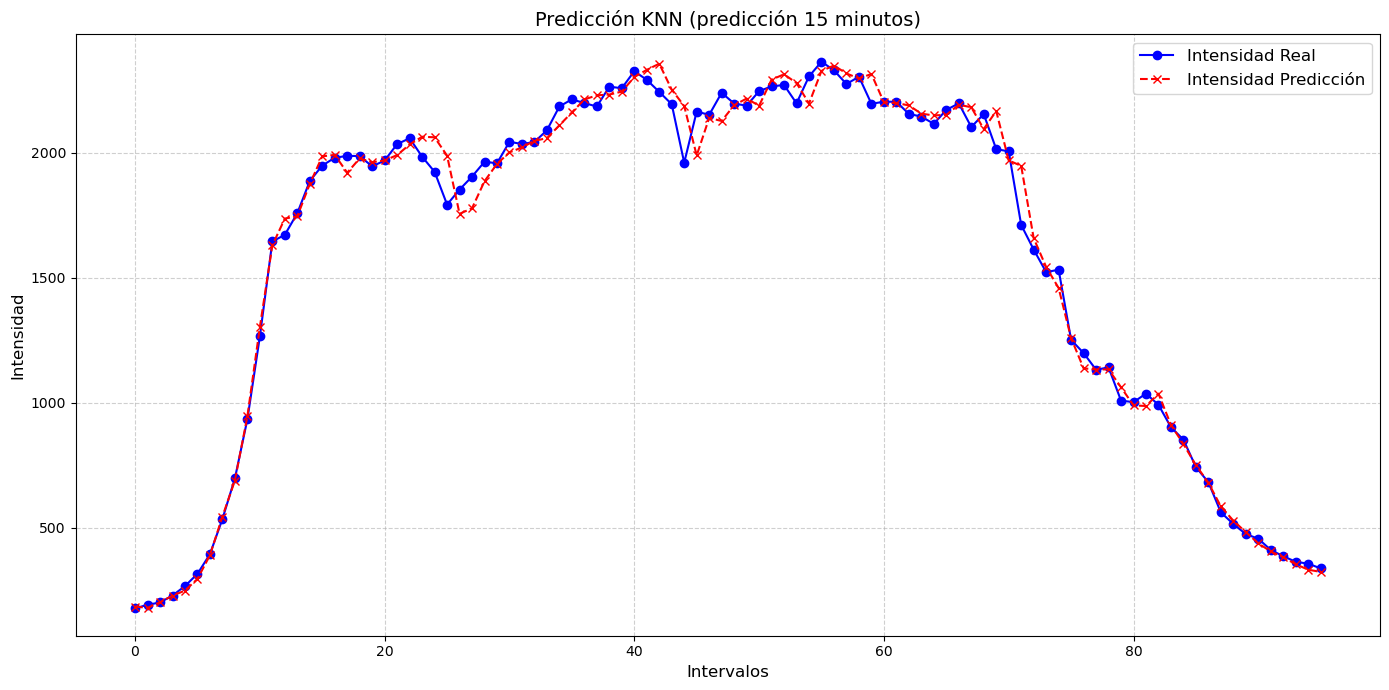

In [51]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 0], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 0], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

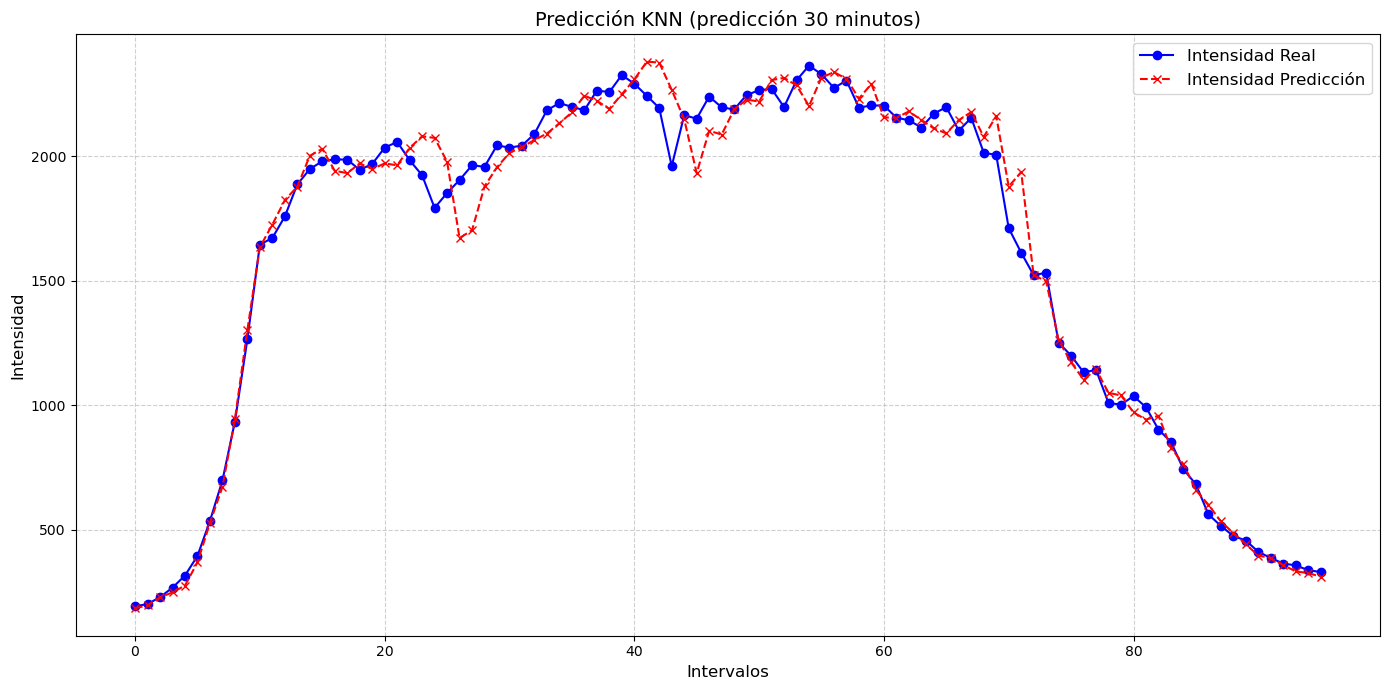

In [52]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 1], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 1], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

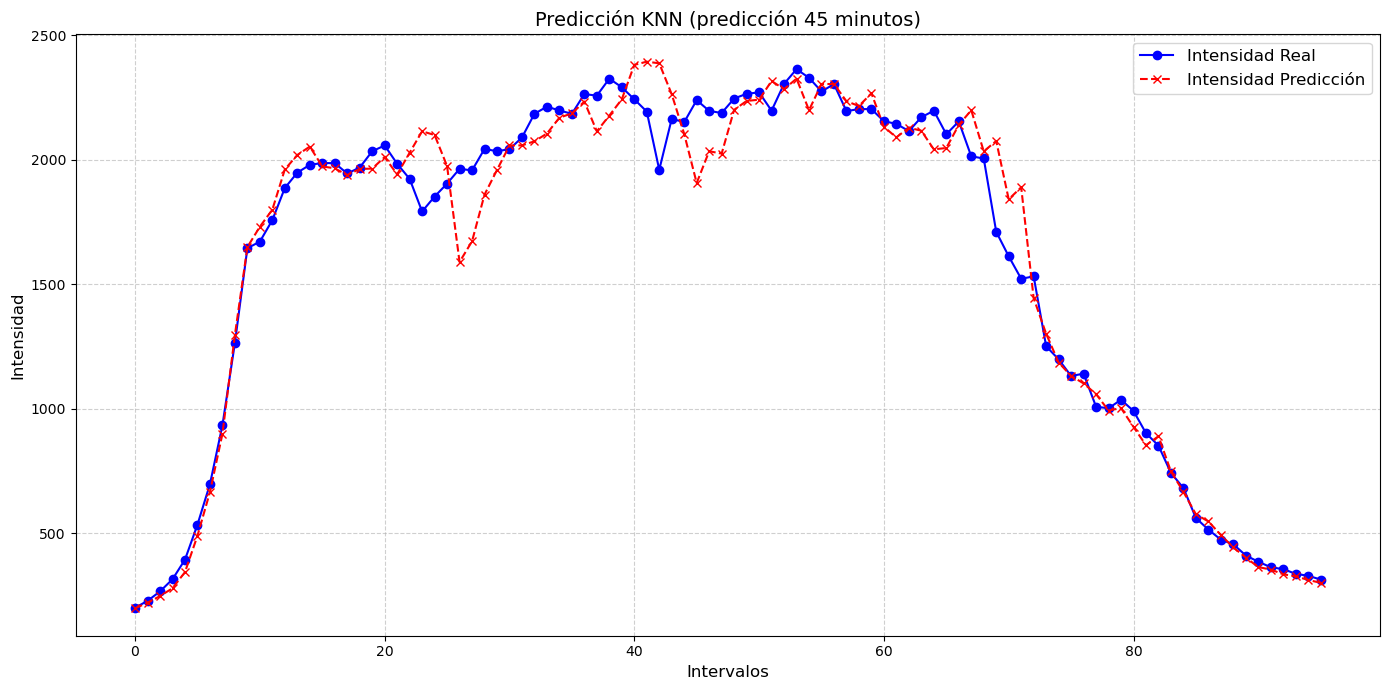

In [53]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 2], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 2], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

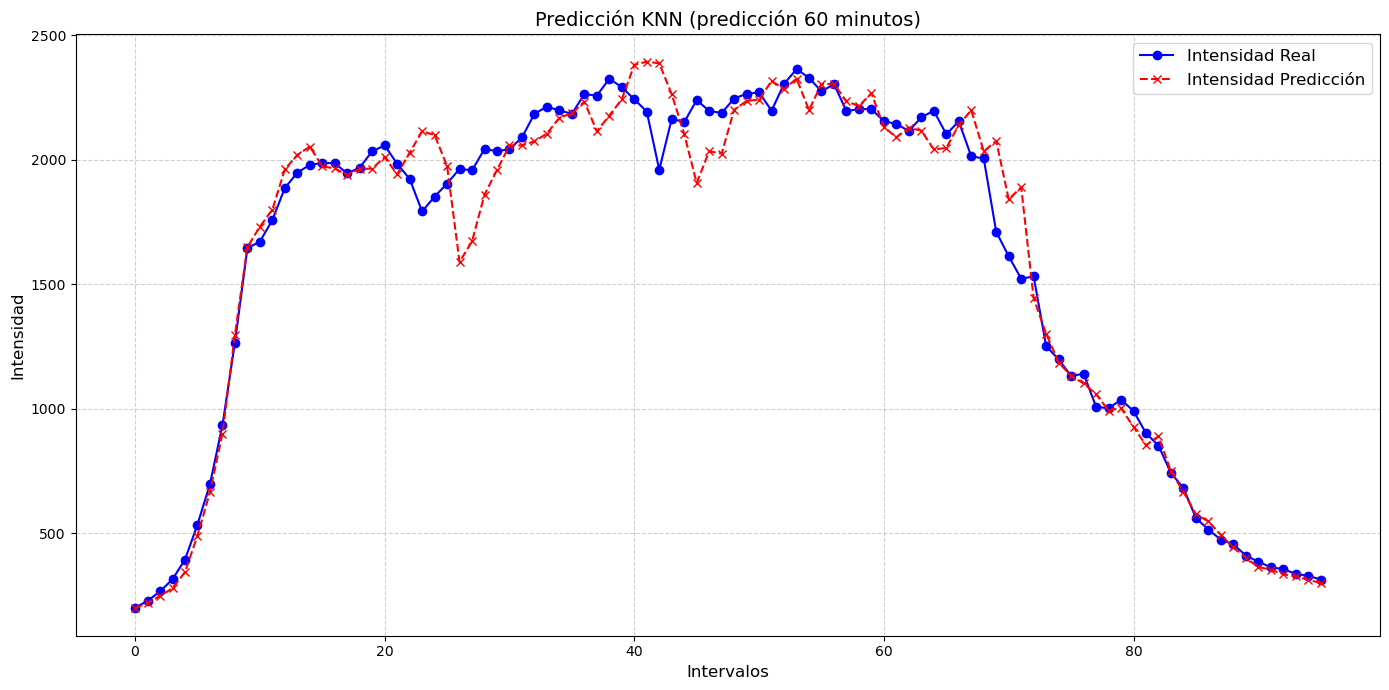

In [54]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_test_original))

plt.plot(
    y_test_original[:num_intervals_to_show, 2], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)
plt.plot(
    y_pred_original[:num_intervals_to_show, 2], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Guardamos el modelo creado

In [55]:
# Ruta para guardar el modelo
ruta_modelo = '/mnt/c/Users/migue/Documents/Python/UNIR/TFE/Todas estaciones/best_KNN_model.pkl'

# Guardamos el modelo
joblib.dump(best_knn_model, ruta_modelo)

print(f"Modelo guardado en {ruta_modelo}")

Modelo guardado en /mnt/c/Users/migue/Documents/Python/UNIR/TFE/Todas estaciones/best_KNN_model.pkl


## Validación con un conjunto de datos no visto por el modelo

In [56]:
# Hacer predicciones
y_pred = best_knn_model.predict(X_prueba)

# Desescalar las predicciones y valores reales
y_pred_original = scaler.inverse_transform(y_pred)
y_prueba_original = scaler.inverse_transform(y_prueba)

# Calcular métricas
mae_steps, mse_steps, rmse_steps, r2_steps = [], [], [], []

for step in range(forecast_steps):
    mae_steps.append(mean_absolute_error(y_prueba[:, step], y_pred[:, step]))
    mse_steps.append(mean_squared_error(y_prueba[:, step], y_pred[:, step]))
    rmse_steps.append(np.sqrt(mse_steps[-1]))
    r2_steps.append(r2_score(y_prueba[:, step], y_pred[:, step]))

# Mostrar métricas por paso
for step in range(forecast_steps):
    print(
        f"Paso {step + 1} - MAE: {mae_steps[step]:.5f}, "
        f"MSE: {mse_steps[step]:.5f}, "
        f"RMSE: {rmse_steps[step]:.5f}, "
        f"R-squared: {r2_steps[step]:.5f}"
    )

Paso 1 - MAE: 0.05832, MSE: 0.00721, RMSE: 0.08493, R-squared: 0.99279
Paso 2 - MAE: 0.08214, MSE: 0.01531, RMSE: 0.12373, R-squared: 0.98470
Paso 3 - MAE: 0.10432, MSE: 0.02559, RMSE: 0.15998, R-squared: 0.97442
Paso 4 - MAE: 0.12551, MSE: 0.03756, RMSE: 0.19380, R-squared: 0.96247


#### Gráficas

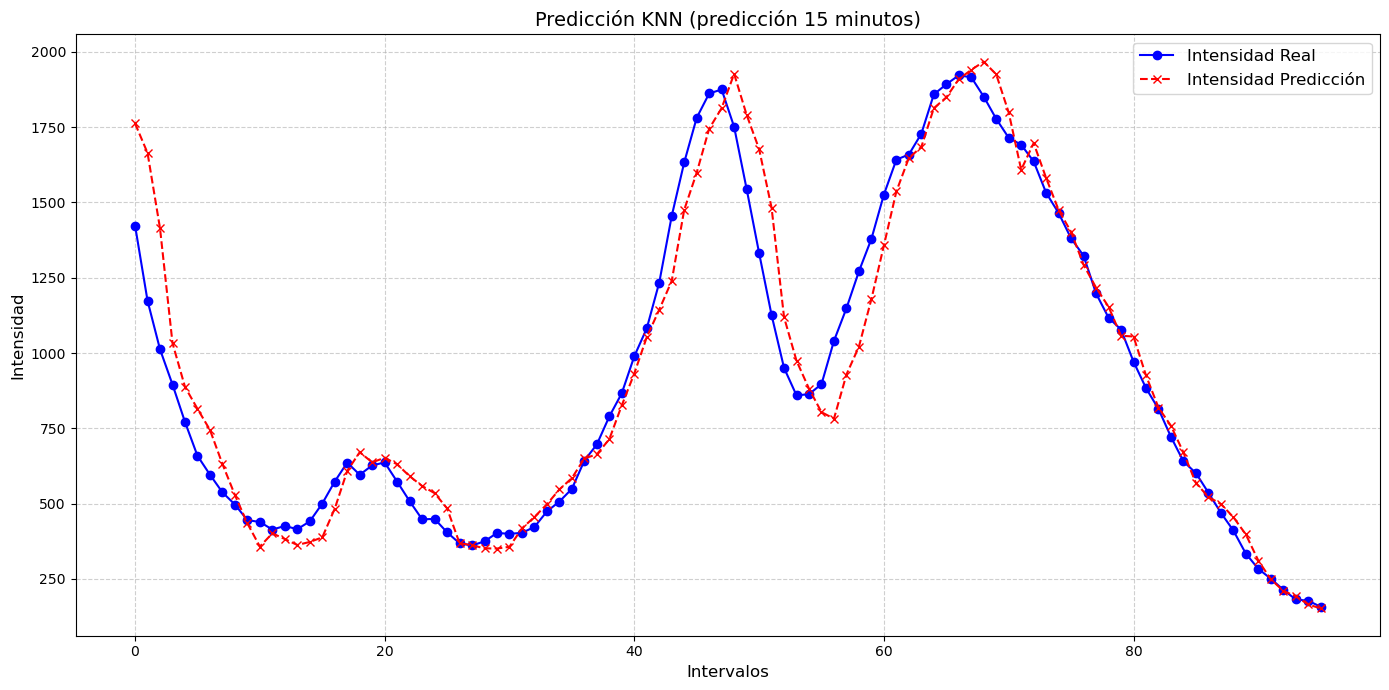

In [57]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 0], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 0], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

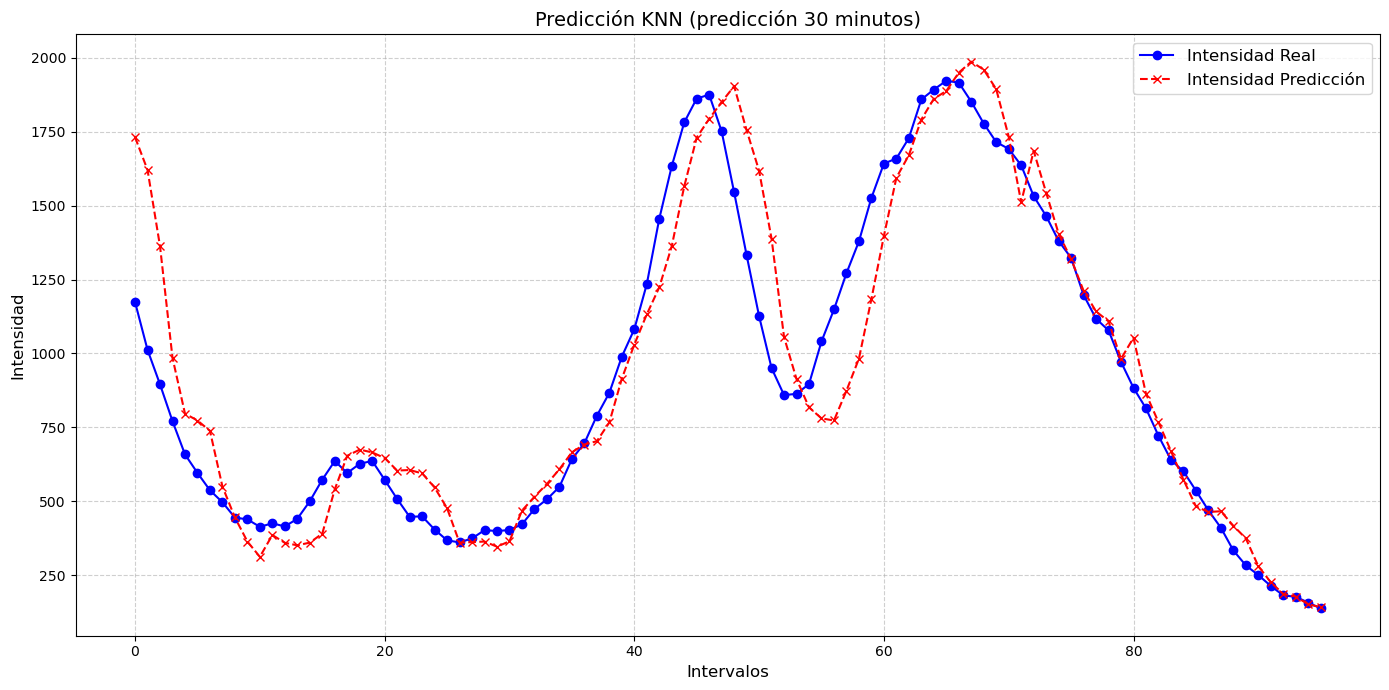

In [58]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 1], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 1], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 30 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

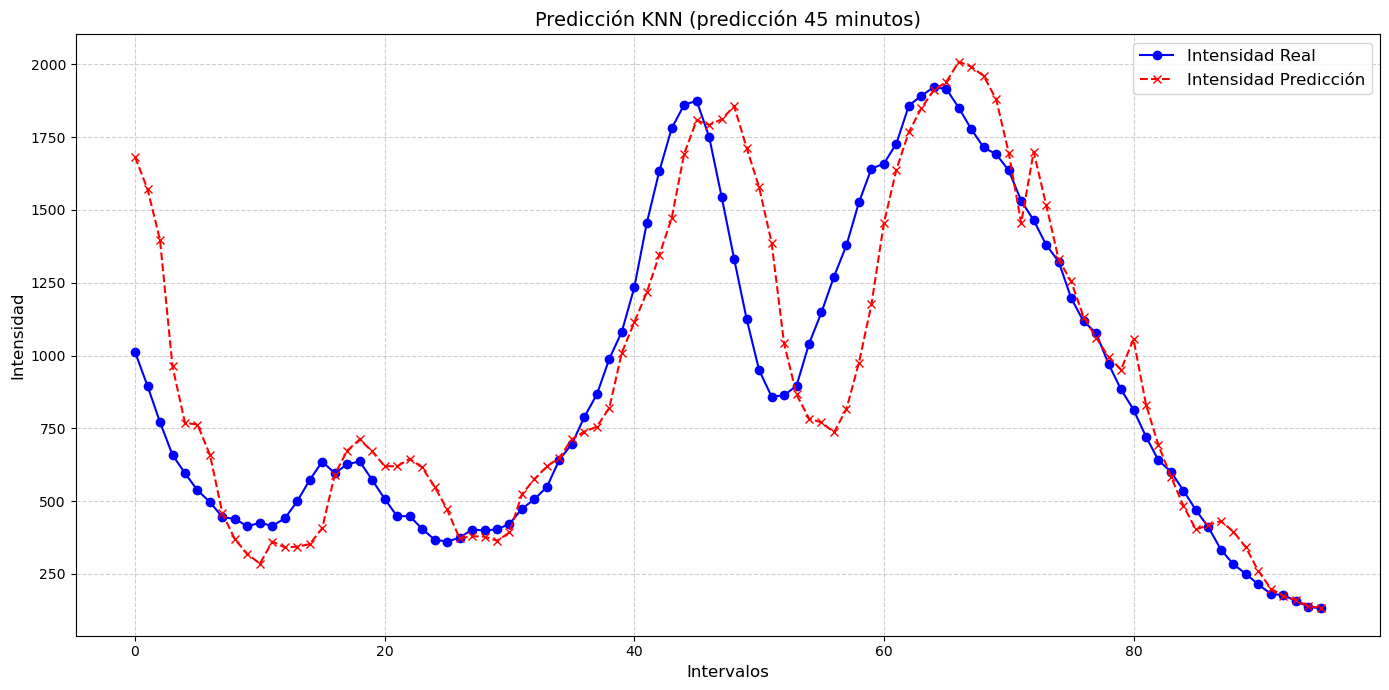

In [59]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 2], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 2], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 45 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

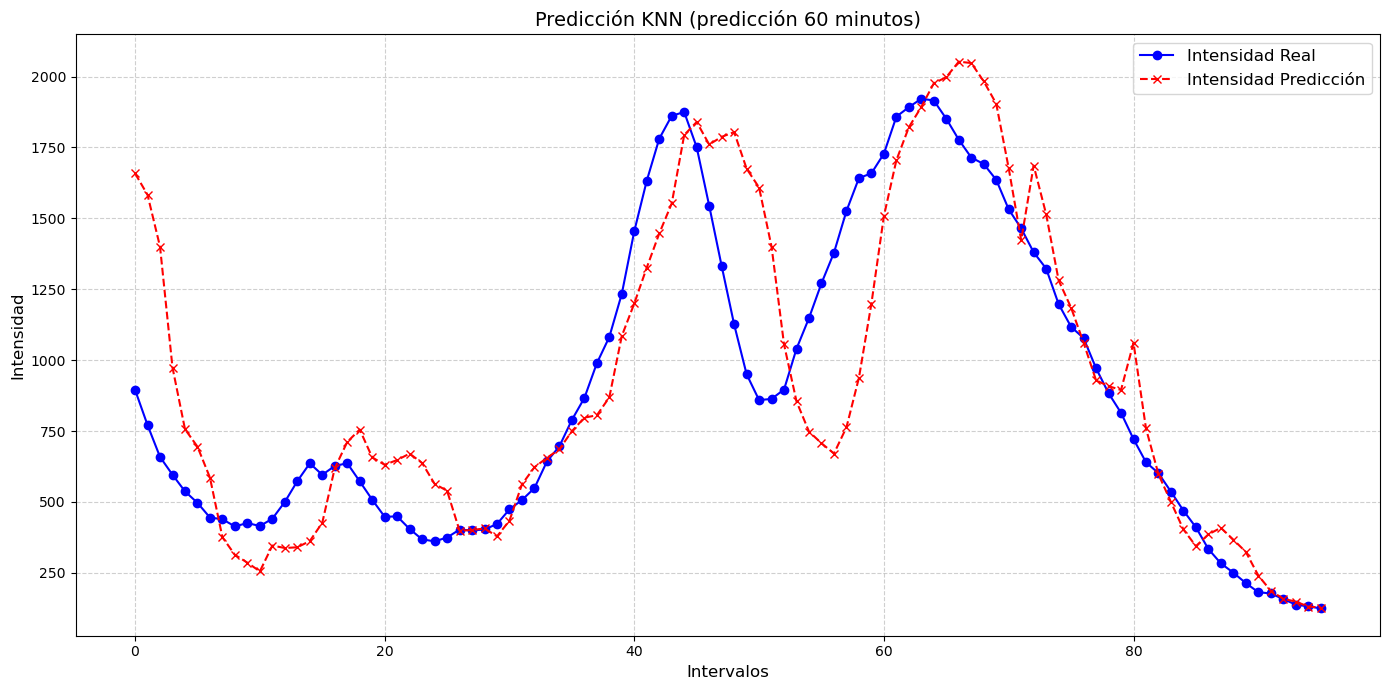

In [60]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_prueba_original))

plt.plot(
    y_prueba_original[:num_intervals_to_show, 3], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 3], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Prueba una única estación  
Probamos el modelo sobre la estación 3490 (Km 10.8 de la M-30).

In [61]:
# Leemos los csv con los datos de entrenamiento
ruta_estacion_prueba = "/mnt/c/Users/migue/Documents/Python/UNIR/TFE/datos_procesados_estaciones_prueba.csv"
df_estacion = pd.read_csv(ruta_estacion_prueba, sep=';', decimal='.')

# Creamos el conjunto con los datos de la estación 3490
datos_3490 = df_estacion[df_estacion['id'] == 3490]

In [62]:
# Preparamos los datos de la estación
# Nos aseguramos que la columna 'fecha' esté en formato datetime
datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])

# Establecemos la fecha como índice
datos_3490 = datos_3490.set_index('fecha')

# Seleccionamos las columnas relevantes para el modelo
df_encoded_3490 = datos_3490['intensidad']

# Escalamos los datos
scaler = StandardScaler()
df_encoded_3490_data_scaled = scaler.fit_transform(df_encoded_3490.values.reshape(-1, 1))

X_3490, y_3490 = create_windowed_dataset(df_encoded_3490_data_scaled, window_size, forecast_steps)

/tmp/ipykernel_1202/2053242435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_3490['fecha'] = pd.to_datetime(datos_3490['fecha'])


In [63]:
# Hacer predicciones
y_pred = best_knn_model.predict(X_3490)

# Desescalar las predicciones y valores reales
y_pred_original = scaler.inverse_transform(y_pred)
y_3490_original = scaler.inverse_transform(y_3490)

# Calcular métricas
mae_steps, mse_steps, rmse_steps, r2_steps = [], [], [], []

for step in range(forecast_steps):
    mae_steps.append(mean_absolute_error(y_3490[:, step], y_pred[:, step]))
    mse_steps.append(mean_squared_error(y_3490[:, step], y_pred[:, step]))
    rmse_steps.append(np.sqrt(mse_steps[-1]))
    r2_steps.append(r2_score(y_3490[:, step], y_pred[:, step]))

# Mostrar métricas por paso
for step in range(forecast_steps):
    print(
        f"Paso {step + 1} - MAE: {mae_steps[step]:.5f}, "
        f"MSE: {mse_steps[step]:.5f}, "
        f"RMSE: {rmse_steps[step]:.5f}, "
        f"R-squared: {r2_steps[step]:.5f}"
    )

Paso 1 - MAE: 0.16179, MSE: 0.06630, RMSE: 0.25749, R-squared: 0.93374
Paso 2 - MAE: 0.20601, MSE: 0.10080, RMSE: 0.31748, R-squared: 0.89927
Paso 3 - MAE: 0.24209, MSE: 0.13076, RMSE: 0.36161, R-squared: 0.86933
Paso 4 - MAE: 0.27057, MSE: 0.15748, RMSE: 0.39684, R-squared: 0.84263


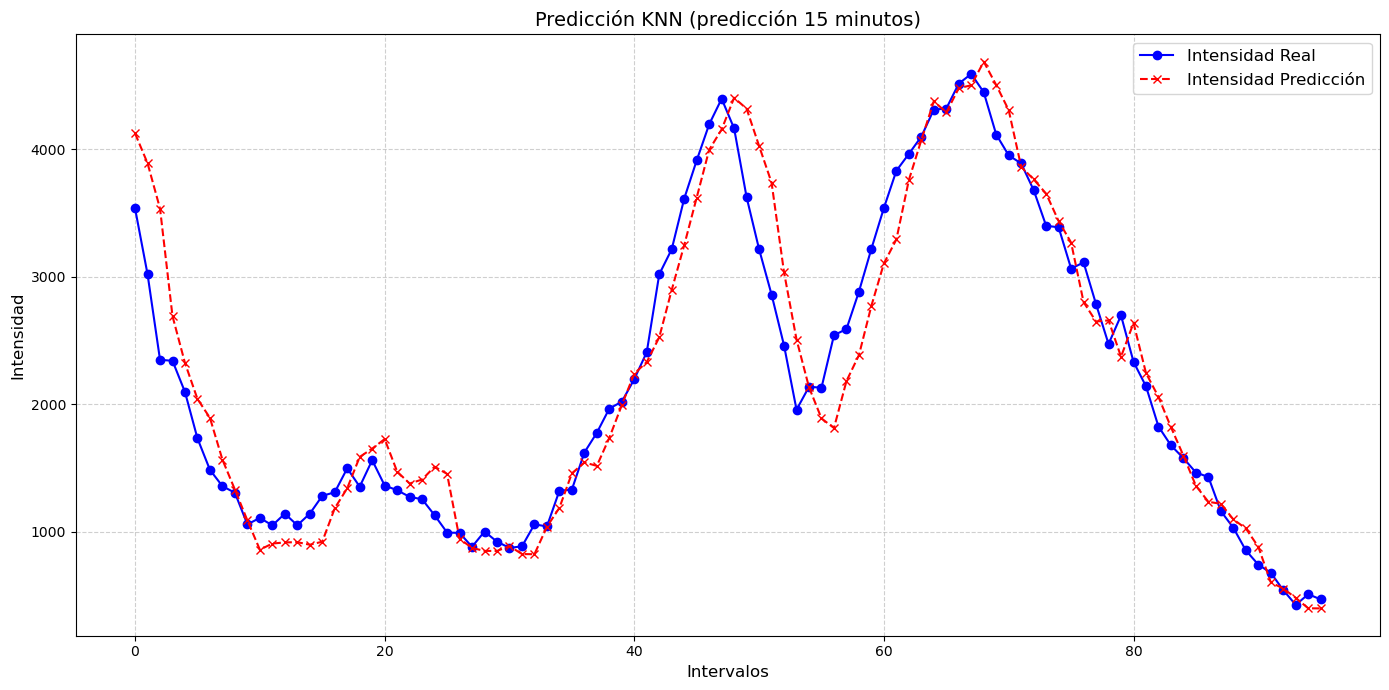

In [64]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_3490_original))

plt.plot(
    y_3490_original[:num_intervals_to_show, 0], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 0], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 15 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

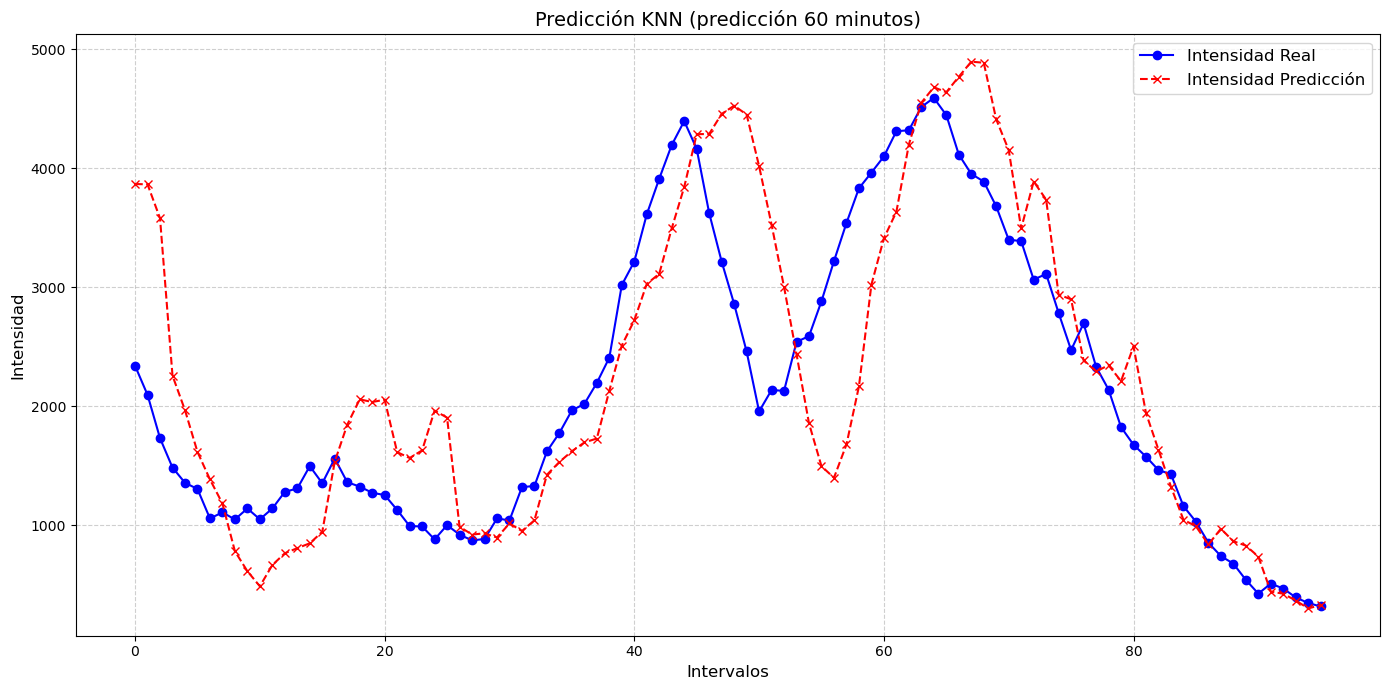

In [65]:
# Graficar resultados en la escala original
plt.figure(figsize=(14, 7))

# Mostrar solo los últimos 96 intervalos o el tamaño de las predicciones disponibles
num_intervals_to_show = min(96, len(y_3490_original))

plt.plot(
    y_3490_original[:num_intervals_to_show, 3], 
    label='Intensidad Real', 
    color='blue', 
    marker='o', 
    linestyle='-'
)

plt.plot(
    y_pred_original[:num_intervals_to_show, 3], 
    label='Intensidad Predicción', 
    color='red', 
    marker='x', 
    linestyle='--'
)

plt.title('Predicción KNN (predicción 60 minutos)', fontsize=14)
plt.xlabel('Intervalos', fontsize=12)
plt.ylabel('Intensidad', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()